In [1]:
import os
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()
 
        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [11]:
from shapely.geometry import Point
from shapely.geometry import box

start_rect = box(13.41616,52.521551,13.416491,52.521769)
end_rect = box(13.415924,52.522282,13.416255,52.5225)

def crop_intersection_SimRa(x):
    mask_first = x.coords.apply(lambda x: start_rect.contains(Point(x)))
    mask_end = x.coords.apply(lambda x: end_rect.contains(Point(x)))
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x.loc[first:last]
    except:
        print('check')
    
    
def crop_intersection_SUMO(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x[['vehicle_x', 'vehicle_y']].loc[first:last].to_numpy()
    except:
        asasd = 12
        #print('check')
        

def plot_location(x, color, alpha, scatter):
    lon = []
    lat = []
    for c in x.coords.values:
        lon.append(c[0])
        lat.append(c[1])
    plt.plot(lon, lat, c=color, alpha=alpha, linewidth= 1)
    if scatter:
        zero_v_coords = x.apply(lambda x: x.coords if x.velos == 0 else None,axis = 1)
        lon = []
        lat = []
        for c in zero_v_coords.values:
            if c == None:
                continue
            lon.append(c[0])
            lat.append(c[1])
        plt.scatter(lon, lat)
        
        
def to_float_arr(x):
    res = []
    for c in x:
        res.append(float(c))
    return res


In [60]:
#all

ped_files = ['VM2_-2112701535', 'VM2_-217686115','VM2_-1247665811','VM2_-104300786', 'VM2_330973206', 'VM2_1100569031', 'VM2_421371629', 'VM2_421371629', 'VM2_1476499235', 'VM2_-1451152685', 'VM2_-1523872256']

all_together = 0

with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.41616,52.521551), st_makepoint(13.416491,52.521769)), 4326))
  AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.415924,52.522282), st_makepoint(13.416255,52.5225)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df = df[~df['filename'].isin(ped_files)]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    
    print("n = ")
    print(len(grouped.groups.keys()))
    all_together = len(grouped.groups.keys())
    
    df_simra = grouped.apply(lambda x: crop_intersection_SimRa(x))
    



n = 
168
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check


In [61]:
#using street
#13.416289,52.521897,13.416437,52.522049


ped_files = ['VM2_-2112701535', 'VM2_-217686115','VM2_-1247665811','VM2_-104300786', 'VM2_330973206', 'VM2_1100569031', 'VM2_421371629', 'VM2_421371629', 'VM2_1476499235', 'VM2_-1451152685', 'VM2_-1523872256']

using_street = 0

with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.41616,52.521551), st_makepoint(13.416491,52.521769)), 4326))
  AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.415924,52.522282), st_makepoint(13.416255,52.5225)), 4326))
    AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.416289,52.521897), st_makepoint(13.416437,52.522049)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df = df[~df['filename'].isin(ped_files)]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    
    print("using street = ")
    print(len(grouped.groups.keys()))
    using_street = len(grouped.groups.keys())

    df_simra_street = grouped.apply(lambda x: crop_intersection_SimRa(x))
    

using street = 
55
check
check
check
check
check
check
check


In [62]:
#using lane
#13.4166,52.521982,13.416823,52.522134


ped_files = ['VM2_-2112701535', 'VM2_-217686115','VM2_-1247665811','VM2_-104300786', 'VM2_330973206', 'VM2_1100569031', 'VM2_421371629', 'VM2_421371629', 'VM2_1476499235', 'VM2_-1451152685', 'VM2_-1523872256']

using_lane = 0

with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.41616,52.521551), st_makepoint(13.416491,52.521769)), 4326))
  AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.415924,52.522282), st_makepoint(13.416255,52.5225)), 4326))
    AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.4166,52.521982), st_makepoint(13.416823,52.522134)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df = df[~df['filename'].isin(ped_files)]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    
    print("using lane = ")
    print(len(grouped.groups.keys()))
    using_lane = len(grouped.groups.keys())

    df_simra_lane = grouped.apply(lambda x: crop_intersection_SimRa(x))
    

using lane = 
99
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check


In [5]:
df_default = pd.read_csv('../sim_data/alex_default.csv', delimiter=';')    
df_im = pd.read_csv('../sim_data/alex_im.csv', delimiter=';')    

dfs=[df_default, df_im]

df_data = []
for df in dfs: 
   res = df.groupby('vehicle_id').apply(lambda x: crop_intersection_SUMO(x)).dropna()
   df_data.append(res.to_numpy())
    

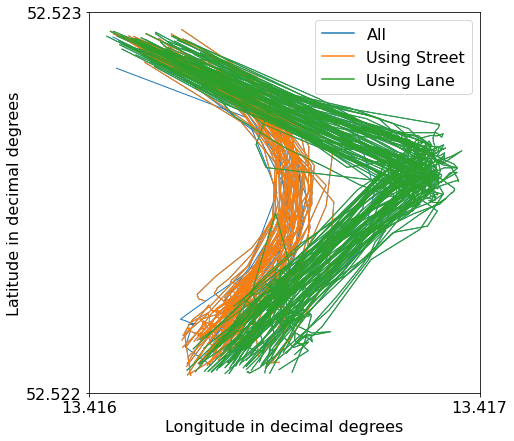

All rides: 168
using Street: 55
using Lane: 99
32.73809523809524% using Street
58.92857142857143% using Lane


In [63]:


from matplotlib import rc

map_data = plt.figure(figsize=(7,7))

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

df_simra.groupby('filename').apply(lambda x: plot_location(x, colors[0], 1, False))
df_simra_street.groupby('filename').apply(lambda x: plot_location(x, colors[1], 1, False))
df_simra_lane.groupby('filename').apply(lambda x: plot_location(x, colors[2], 1, False))

#for ride in df_data[0]:
#    plt.plot(ride[:,0], ride[:,1],c ='r', alpha=.7)


xmin, xmax, ymin, ymax = plt.axis()
plt.xticks([xmin, xmax], [round(xmin, 3), round(xmax, 3)])
plt.xlabel('Longitude in decimal degrees')
plt.yticks([ymin, ymax], [round(ymin, 3), round(ymax, 3)])
plt.ylabel('Latitude in decimal degrees')
plt.plot([], c=colors[0], label='All')
plt.plot([], c=colors[1], label='Using Street')
plt.plot([], c=colors[2], label='Using Lane')
plt.legend(loc='upper right')
#plt.savefig('images/im_alex_default_simra_loc.png', dpi=300, bbox_inches='tight')
plt.show()

print("All rides: " + str(all_together))
print("using Street: " + str(using_street))
print("using Lane: " + str(using_lane))

print(str((using_street/all_together)*100)+"% using Street")
print(str((using_lane/all_together)*100)+"% using Lane")


